In [1]:
from IPython.display import Audio

In [2]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

# What does a sinusoid sound like?

We all have advanced frequency detectors in our ears. This notebook will show how listening to signals gives you a whole different way to understand the frequency domain.

We start by constructing a musically relevant note as a pure sine wave

In [48]:
fs = 44100  # sampling frequency, Hz This is the rate at which CDs are sampled.
T = 0.5  # note length, seconds
A = 440  # Note frequency, Hz
twopi = 2*numpy.pi

t = numpy.linspace(0, T, int(T*fs), endpoint=False) # time variable
dt = t[1]  # Sampling time
def note(frequency):
    return numpy.sin(twopi*frequency*t)                # pure sine wave at 440 Hz

# load a NumPy array
Audio(note(A), rate=fs)

Now we construct the Chromatic 12 note scale:

[Chromatic scale](https://en.wikipedia.org/wiki/Twelfth_root_of_two)

In [49]:
scalet = numpy.linspace(0, T*13, int(T*fs*13), endpoint=False)
scale = numpy.concatenate([note(A*2**(i/12.)) for i in range(13)])    

In [50]:
Audio(scale, rate=fs)

Of course, this is quite a large number of points, you can't really see what's going on

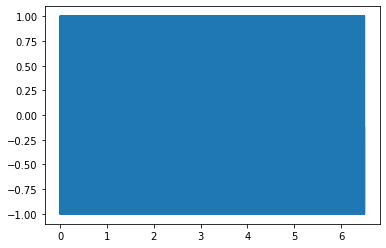

In [55]:
plt.plot(scalet, scale)

You can see the sinusoids better if you zoom in

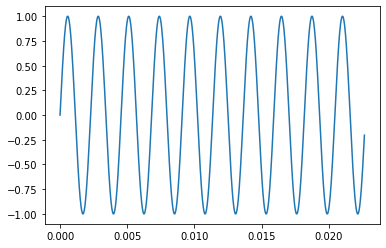

In [56]:
Nzoom = 1000
plt.plot(scalet[:Nzoom], scale[:Nzoom])

Let's listen to the effect of running this through a first order filter.

$$G_f = \frac{1}{\tau s + 1}$$

We'll use the convolution, so we first obtain the impulse response of the filter

In [57]:
omega = 440*twopi  # (440 cycles/second)*(2 pi radians / cycle)
tau = 1/omega
first_order_impulse = numpy.exp(-t/tau)

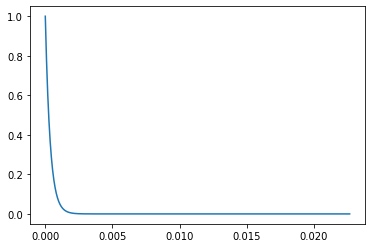

In [58]:
plt.plot(t[:Nzoom], first_order_impulse[:Nzoom])

Then we calculate the output signal via convolution. Recall that when we wrote $y(s) = G_f(s)u(s)$, this was equivalent to calculating $y(t) = g_f(t)*u(t)$ where the $*$ represents convolution. In this case the filtered signal is $y(t)$ and the original scale is $u(t)$.

In [59]:
def filtersignal(signal):
    return numpy.convolve(signal, first_order_impulse, 'same')/len(signal)*len(first_order_impulse)

In [60]:
filtered = filtersignal(scale)

As a side note: This is not how filtering is done in practice, you can see this process takes a while.

In [61]:
Audio(filtered, rate=fs)

Can you hear how the sound gets softer as the frequency goes up? This is the effect of the filter. If we plot the whole waveform we can clearly see the amplitude going down in steps.

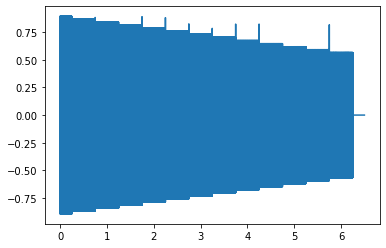

In [13]:
plt.plot(scalet, filtered)

When we zoom in so that we can see the wave forms, we can see that the low frequencies are attenuated less than the high frequencies.

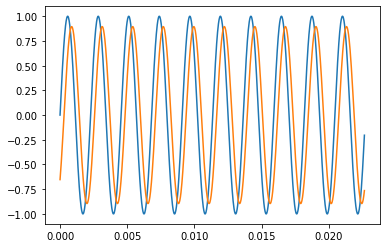

In [62]:
plt.plot(scalet[:Nzoom], scale[:Nzoom],
         scalet[:Nzoom], filtered[:Nzoom])

In [63]:
start = int(fs/T)*3

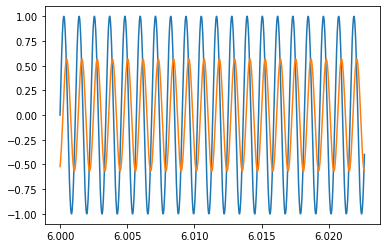

In [64]:
plt.plot(scalet[start:start+Nzoom], scale[start:start+Nzoom],
         scalet[start:start+Nzoom], filtered[start:start+Nzoom])

## But signals aren't pure sinusoids

Why have I chosen pure sinusoids to play with here? Because they can be combined to form all the other signals via Fourier series. Just to show that everything still works even when we don't have pure sinusoids, let's form a chord, which will be three sinusoids playing together. I'll build a [major chord](https://en.wikipedia.org/wiki/Major_chord) in just intonation.

I'll also use the highest note an octave higher so that we can hear the filtering effect more clearly. I'm using `tile` here to repeat the sample a couple of times to make the sound longer.

In [65]:
notes = [A, A*5/4, A*3/2*2]

In [66]:
chord = numpy.tile(1/len(notes)*sum(note(n) for n in notes), 3)

We can see that this is no longer a simple sinusoid

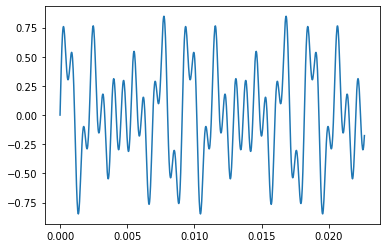

In [67]:
plt.plot(scalet[:Nzoom], chord[:Nzoom])

In [68]:
Audio(chord, rate=fs)

In [69]:
filtered = filtersignal(chord)

In [70]:
Audio(filtered, rate=fs)

## Numeric Fourier Transform
We can obtain an approximation of a Fourier transform of a signal by using the Fast Fourier Transform (fft). Functions relating to the fft are found in `numpy.fft`. 

First we calculate the fft using `rfft`. The r stands for "real", because we have a signal containing only real values. If we use `numpy.fft.fft` it assumes that the signal could contain complex values and returns twice as many values. `numpy.fft.tfftfreq` is used to calculate the frequencies for which `rfft` has calculated the values.

In [74]:
fft = numpy.fft.rfft(chord)
fftfreq = numpy.fft.rfftfreq(len(chord), dt)

When we plot the gain part of this signal, we can clearly see the peaks at the frequencies of the sinusoids from before.

In [75]:
def bodegain(fft):
    plt.loglog(fftfreq, numpy.abs(fft))
    
def shownotes():
    for n in notes:
        plt.axvline(n, color='grey', alpha=0.8)

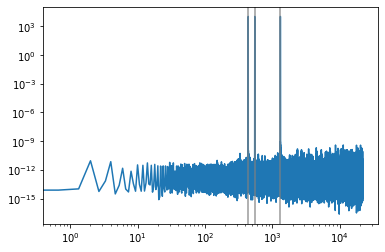

In [76]:
bodegain(fft)
shownotes()

Now, let's look at the filtered version

In [77]:
filtered_fft = numpy.fft.rfft(filtered)

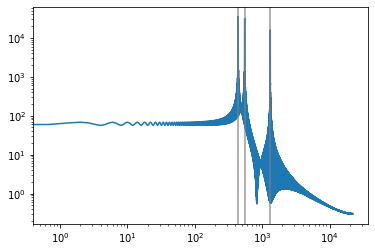

In [78]:
bodegain(filtered_fft)
shownotes()

It's clear how the lower frequencies are attenuated (made smaller) by the filter.

We can also work backwards from the measured signals to obtain the frequency response of the system. Consider that 

$$G(s) = \frac{y(s)}{u(s)} \quad \text{so} \quad G(i\omega) = \frac{y(i\omega)}{u(i\omega)}$$

In [79]:
Gfreq = filtered_fft/fft

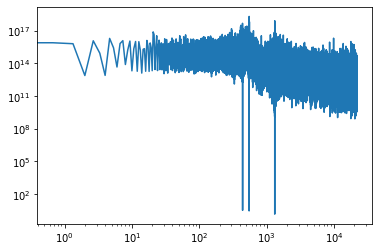

In [80]:
plt.loglog(fftfreq, numpy.abs(Gfreq))

The gain is a bit strange (very large) here because we used a pure sinusoidal signal to start with, with no low frequency content, but we can still see the characteristic shape of a first order transfer function.

## But that sounds terrible

Pure sinusoids are not in fact all that musical, let's rather use a proper song.

You can convert from MP3 to wav using one of [these techniques](http://www.wikihow.com/Convert-MP3-to-WAV)

In [81]:
import scipy.io.wavfile

I've used "Wedding Day" by SAINt JHN here. I think 7 seconds falls within fair use. You might want to use your own favourite song to hear the differences clearly.

In [88]:
samplingrate, song = scipy.io.wavfile.read('../../assets/weddingday.wav')

In [89]:
dt = 1/samplingrate

In [90]:
samplelength = 7*samplingrate
songsample = song.sum(axis=1)[:samplelength]

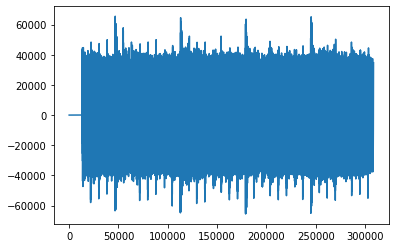

In [91]:
plt.plot(songsample)

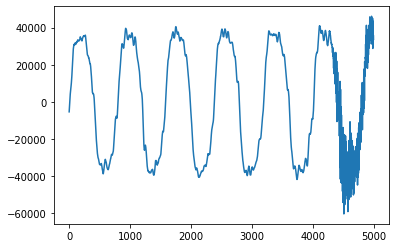

In [92]:
plt.plot(songsample[100000:105000])

Let's first hear what it sounds like unfiltered.

In [99]:
songsample[100000:105000]

array([-5346, -4772, -4268, ..., 35405, 34417, 33684])

In [93]:
Audio(songsample, rate=samplingrate)

Now with one pass through the filter

In [94]:
filtered = filtersignal(songsample)
Audio(filtered, rate=samplingrate)

We can filter the signal a second time to really hear the high notes fall away.

In [96]:
filtered = filtersignal(filtered)
Audio(filtered, rate=samplingrate)

In [97]:
songfft = numpy.fft.rfft(songsample)
filteredfft = numpy.fft.rfft(filtered)
fftfreq = numpy.fft.rfftfreq(len(songsample), dt)

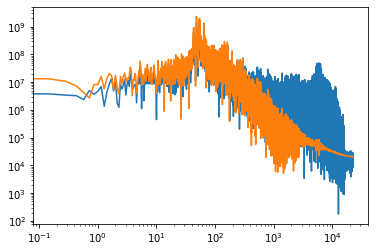

In [98]:
bodegain(songfft)
bodegain(filteredfft)

Let's see what the effect of the filter looks like as a function of frequency.

In [41]:
Gfft = filteredfft/songfft

In [42]:
omega = numpy.logspace(0, 5, 1000)

In [43]:
s = 1j*omega

In [44]:
Gw = 1/(tau*s + 1)

In [45]:
gain = numpy.abs(Gw)

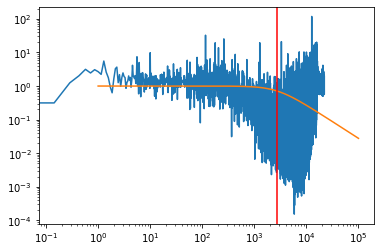

In [46]:
plt.loglog(fftfreq, numpy.abs(Gfft))
plt.loglog(omega, gain)
plt.axvline(1/tau, color='red')